# Additional analysis for Drug Adverse Events

## Co-occuring drugs

With the adverse events database, it possible to determine which drugs are taken together. In order to analyse this, we will use some example drugs. In particular, we will focus on some cancer cure medicines. 

For the purposes of this analysis, we will consider the following drugs: (source : https://www.cancer.gov/about-cancer/treatment/drugs/brain)

1. Afinitor
2. Avastin
3. Carmustine
4. QUETIAPINE FUMARATE (From the previous study)

In [1]:
%matplotlib inline

import requests
import json
try:
    from config import api_key #import the api_key
except ImportError:
    pass

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [128]:
plt.rcParams["figure.figsize"] = (15,7)
plt.style.use('ggplot')

product_list=['afinitor', 'avastin', 'carmustine','QUETIAPINE']

In [76]:
def get_total_records(product_name):
    """Get the number of records for a particular product (to do pagination: number of records limited to 1000 per call)"""
    
    base_url="https://api.fda.gov/drug/event.json"
    headers={"api_key": api_key}
    search_term=f'?search={product_name}+AND+primarysource.qualification:1&limit=1'
    request_url=base_url+search_term
    response=requests.get(request_url,headers=headers).json()
    if "error" in response:
        print("Error in query message")
        return None
    else:
        #Search query can give the total number of records, we can recursively use them to pagination (skip/limit)
        return response['meta']['results']['total']

def request_openfda(product_name,limit=1000, skip=0):
    """Request data from openFDA based on page (skip and limit)"""
    base_url="https://api.fda.gov/drug/event.json"
    headers={"api_key": api_key}
    search_term=f'?search={product_name}+AND+primarysource.qualification:1&limit={limit}&skip={skip}'
    
    request_url =base_url+search_term
    response=requests.get(request_url,headers=headers).json()
    if "error" in response:
        print(f"Error in query message {search_term}")
        return None
    else:
        #Search query can give the total number of records, we can recursively use them to pagination (skip/limit)
        return response['results']
    
def process_product(results):
    """Calculate co-occuring products"""
    
    co_occur={}
    for page in results:
        for result in page:
            if 'patient' in result.keys():
                for drug in result['patient']['drug']:
                    key=drug['medicinalproduct']
                    co_occur[key]=co_occur.get(key,0)+1 # Add key if not exist, else increment by 1 (count)
    co_occur={ k: v for k, v in co_occur.items() if v >= 50 } #We are interested in only the most frequent 50
    return co_occur


def process_events(results):
    """Calculate the number of events reported for proportionality analysis"""
    
    events={}
    for page in results:
        for result in page:
            if 'patient' in result.keys():
                for reaction in result['patient']['reaction']:
                    key=reaction['reactionmeddrapt']
                    events[key]=events.get(key,0)+1
    events={ k: v for k, v in events.items() if v >= 20 }
    return events
    

 
def extract_pages(search_term):
    """
    Get all the records for the particular search term
    
    Returns:
        list of dicts: records for each page (list)
       
    """
    total_records=get_total_records(search_term)
    print(total_records)
    
    limit=1000 # Limit of openfda access
    offset=0
    max_records=25000 # 
    count=0
    results=[]#Capture all the page results into this mega list
    
    if total_records>limit:
        if total_records>max_records:
            total_records=max_records# If the number of records exceed 25,000, limit them for API access
        count=total_records//limit #num of pages
    elif total_records<limit:
        #No. of records is less than limit- no need for pages
        response=request_openfda(search_term,limit,offset)#get response 
        results.append(response)#append all the pages in to a list (results)
        
            
        
    #iterate over each page
    for i in range(1,count+1):
        response=request_openfda(search_term,limit,offset)#get response for each page (1000 records)
        results.append(response)#append all the pages in to a list (results)
        offset=i*record_count # increment the page skip (offset)
    
    return results
        
def barplot(x,y,df,xlabel,ylabel, title=None):
    """
    Plot a simple count based on a dataframe
    
    Args:
    x (str): pandas column name to use as x axis (default:"term")
    y (str): pandas column name to use as y axis (default:"count")
    df (pandas dataframe): pandas dataframe object consisting the data to plot
    xlabel (str): x-label
    ylabel (str): y-label
    titl (str): Title for the plot (default: None)
    
    """
    plt.figure()
    ax = sns.barplot(x=x, y=y, data=df,palette='Set1')
    ax.set(xlabel=xlabel, ylabel=ylabel)
    ax.set(title=title)
    plt.xticks(
        rotation=45, 
        horizontalalignment='right',
        fontweight='medium',
        fontsize='x-large'  
    );
        


In [71]:
product_cooccurence=[]
# Get which product co-occur in reports (drugs tend to be taken together)
for product in product_list:
    print(f'Processing {product}')
    results=extract_pages(product)
    co_occur=process_product(results)
    product_cooccurence.append(co_occur)
    
    


Processing afinitor
10934
Processing avastin
37950
Processing carmustine
1156
Processing QUETIAPINE
32407


In [140]:
df=pd.DataFrame(product_cooccurence)
df=df.fillna(0)
df['Drug Name']=product_list
df.describe()


,XGEVA,AFINITOR,EXEMESTANE,METFORMIN,BISOPROLOL,EVEROLIMUS,EXEMESTANE.,ONDANSETRON,SYNTHROID,ZOMETA,...,CYCLOBENZAPRINE.,NUPLAZID,AMANTADINE.,PRAZOSIN.,LACOSAMIDE.,INGREZZA,METHADONE HCL,CITALOPRAM HYDROBROMIDE,TRAZODONE HCL,ALBUTEROL
count,4.000000,4.000000,4.00,4.000000,4.000000,4.00000,4.000000,4.000000,4.000000,4.000000,...,4.0,4.0,4.0,4.00,4.00,4.00,4.00,4.00,4.00,4.00
mean,90.000000,2542.250000,27.75,256.000000,170.000000,448.75000,320.750000,239.500000,141.000000,143.750000,...,24.0,193.5,18.5,15.75,16.75,36.25,21.25,34.75,41.25,32.25
std,115.956889,4992.263373,55.50,280.232047,147.993243,863.18147,607.975534,323.975822,160.787645,167.392503,...,48.0,387.0,37.0,31.50,33.50,72.50,42.50,69.50,82.50,64.50
min,0.000000,0.000000,0.00,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.000000,0.000000,0.00,85.500000,81.000000,0.00000,0.000000,51.000000,47.250000,0.000000,...,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,58.500000,69.500000,0.00,190.500000,169.500000,26.00000,25.500000,122.500000,98.000000,130.500000,...,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00
75%,148.500000,2611.750000,27.75,361.000000,258.500000,474.75000,346.250000,311.000000,191.750000,274.250000,...,24.0,193.5,18.5,15.75,16.75,36.25,21.25,34.75,41.25,32.25
max,243.000000,10030.000000,111.00,643.000000,341.000000,1743.00000,1232.000000,713.000000,368.000000,314.000000,...,96.0,774.0,74.0,63.00,67.00,145.00,85.00,139.00,165.00,129.00


The above table summarises the most common drugs taken together for the four drugs under consideration. Most drugs are related to cancer/chemotherapy. Metformin is a diabetes medicine, however, it is also used for treatment of cancer (reponse to treatment, reduce relapse etc) source [https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6497052/#:~:text=Generally%2C%20metformin%20can%3A%201),and%206)%20reduce%20the%20damaging]

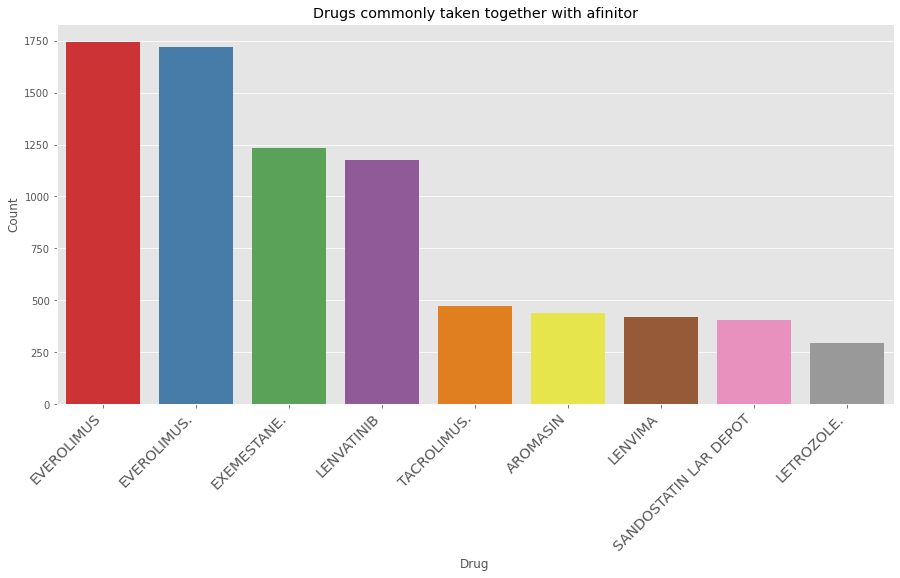

In [129]:
#Analysis for Afinitor
df1=df[df['Drug Name']==product_list[0]].drop(['Drug Name'],axis=1)
top_10=df1.T.sort_values(by=0, ascending=False)[1:10]
top_10=top_10.reset_index().rename(columns={"index":"Names", 0:"Count"})
barplot(x="Names", y="Count", df=top_10, xlabel="Drug", ylabel="Count", title=f"Drugs commonly taken together with {product_list[0]}")

#barplot(x=top_10[0], index, )


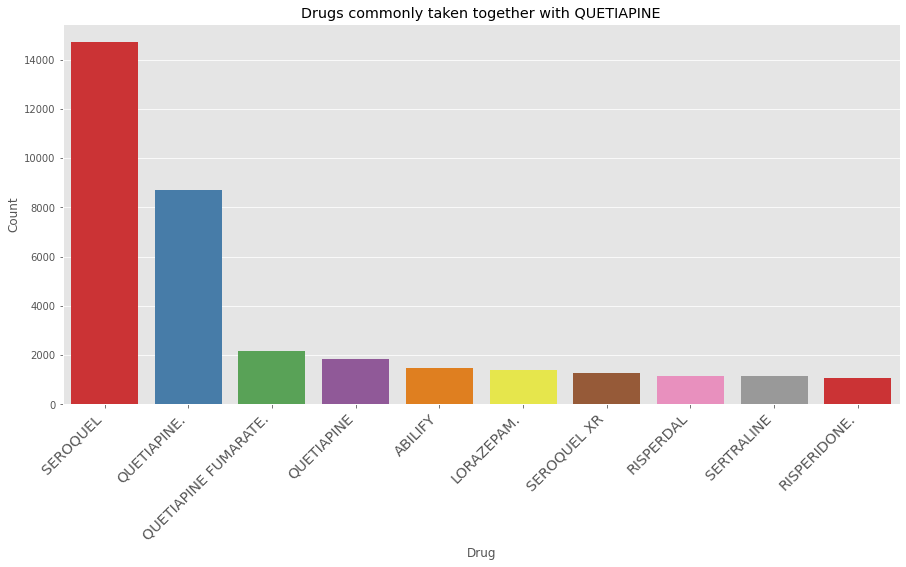

In [139]:
#Analysis for Quetiapine
df1=df[df['Drug Name']==product_list[-1]].drop(['Drug Name'],axis=1)
top_10=df1.T.sort_values(by=3, ascending=False)[0:10]
top_10=top_10.reset_index().rename(columns={"index":"Names", 3:"Count"})

barplot(x="Names", y="Count", df=top_10, xlabel="Drug", ylabel="Count", title=f"Drugs commonly taken together with {product_list[-1]}")

#barplot(x=top_10[0], index, )


We analysed which particular drugs are taken together for two drugs: Afinitor and Quetiapine. 

1. Afinitor is used for the treatement of the cancer. Similar cancer treating drugs are taken together.
2. Quetiapine is an anti-psycotic drug: Lorazepam is used for sleeping and calming people down. Other anti-psycotic drugs such as risperdal and anti-depressants (Sertraline).
3. From the above, the name of the drugs are reported in various forms and thus need to be combined using some form of text processing.

## Disproportionality Analysis

Safety reports are generally analysed for statistical associations between products and events in the database. These methods compare the observed count for a product-event combination with an expected count. Unexpected high associations may indicate a causal association between the adverse event and the product. 

Proportional Reporting Ratio is used as a measure to analyse the product-event combination and is defined as the degree of disproportionate reporting of an adverse event for a product of interest compared to this same event for all other products in the database. It should be noted that this measure is a statistical association and cannot be interpreted as causal or related to risk. 

This concept of disproportionality may be displayed by means of a contingency table where (https://www.fda.gov/science-research/data-mining/data-mining-fda-white-paper)

- “a” is all reports for a specific adverse event (“Event Y”) for Product (e.g. a drug) X,
- “b” is all reports for all other adverse events for Product X,
- “a + b” are all the reports for Product X,
- “c” is all reports for all other products for Event Y,
- “d” is all reports for all other products for all other adverse event, and
- “c + d” is all reports for all other products.


|               | Event Y       |All other events|              |
| ------------- | ------------- |----------------|--------------|
| product X     | a  |b|a+b|
| All other products  | c  | d  | c+d  |
|               | a+c | b+d  | total  |


The PRR=[a/(a+b)]/[c/(c+d)], if the numerator ratio is greater than denominator ratio, then Event Y is disproportionately reported for product X. However, when you have small number of observed events or expected events this metric is not suitable. Gamma Poisson Shrinker (GPS) and Empirical Bayes Geometric Mean (EBGM) are used. 

In this notebook, we will format the data in the right format for analysis. As above, we will focus on the products mentioned earlier.

In [144]:
# Getting the product event counts

product_event=[]
# Get which product co-occur in reports (drugs tend to be taken together)
for product in product_list:
    print(f'Processing {product}')
    results=extract_pages(product)
    prod_events=process_events(results)
    product_event.append(prod_events)
    
    

Processing afinitor
10934
Processing avastin
37950
Processing carmustine
1156
Processing QUETIAPINE
32407


In [151]:
df=pd.DataFrame(product_event)
df=df.fillna(0)
df['Drug Name']=product_list
df=df.set_index("Drug Name")
df

,Metastases to bone,Osteonecrosis of jaw,Epilepsy,Stomatitis,Angioedema,Flushing,Erythema,Skin exfoliation,Swelling,Pruritus,...,TYPE 2 DIABETES MELLITUS,TYPE 1 DIABETES MELLITUS,POISONING,HEPATITIS,INCORRECT DOSE ADMINISTERED,WITHDRAWAL SYNDROME,DRUG WITHDRAWAL SYNDROME NEONATAL,POISONING DELIBERATE,SOMNAMBULISM,DRUG ABUSE
Drug Name,,,,,,,,,,,,,,,,,,,,,
afinitor,240.0,127.0,20.0,667,28.0,49.0,102.0,37.0,63.0,166.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
avastin,89.0,143.0,61.0,305,0.0,37.0,158.0,0.0,0.0,103.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
carmustine,0.0,0.0,0.0,23,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
QUETIAPINE,0.0,0.0,100.0,31,38.0,0.0,68.0,24.0,0.0,84.0,...,65.0,21.0,120.0,26.0,36.0,21.0,20.0,30.0,26.0,36.0


We have now a dataset of product-event occurences. We have 1249 events associated with 4 drugs. We will save them for further analysis

In [153]:
df.to_csv('./data/product_event.csv')

In [164]:
def process_events_R(results, drug_name):
    """Collate the data into the format for Calculate the events reported for proportionality analysis"""
    
    events=[]
    for page in results:
        for result in page:
            if 'patient' in result.keys():
                if 'patientsex' in result['patient'].keys():
                    sex=result['patient']['patientsex']
                else:
                    sex=None
                if 'patientonsetage' in result['patient'].keys():
                    age=result['patient']['patientonsetage']
                else:
                    age=None
                    
                
                for reaction in result['patient']['reaction']:
                    effect=reaction['reactionmeddrapt']
                    events.append({'sex':sex, 'age':age, "var1":drug_name,"var2":effect})
    #events={ k: v for k, v in events.items() if v >= 20 }
    return events
    

In [165]:
product="afinitor"
results=extract_pages(product)
events=process_events_R(results, product)

10934
